# Analysis of models that predict ENSO well
- takes the models that show similar ENSO states following Krakatoa 
(an El Nino in DJF 1884 or 1885 AND a La Nina in DJF 1886)
- creates spatial plots of tas and pr for nino models, nina models and then al

In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import seaborn as sns
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 

In [4]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


In [5]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [6]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [7]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [8]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [9]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [31]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


In [45]:
# area weighting 
models_w = models*np.cos(models.lat*(np.pi/180))

In [46]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])
# e_pre5yrs = ['1878-08','1897-10', '1958-03', '1977-04', '1986-06']
# e_pre3mon = ['1883-05','1902-7', '1962-12', '1982-01', '1991-03']
# e_post5yrs = ['1888-08','1907-10', '1968-03', '1987-04', '1996-06']

## Anomalies 

In [47]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axi

In [141]:
# use functions to calculate the monthly anomalies for the globe and take the multi model mean 
K_mon_Glob = func.monthly_anomaly(models_w, '1850-01', '1881-01')

In [142]:
# select out regions for other anomalies 
K_mon_SH = K_mon_Glob.sel(lat=slice(-90,0)) 
K_mon_NH = K_mon_Glob.sel(lat=slice(0,90)) 
K_mon_Aus = K_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
K_mon_EA = K_mon_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

# select out models that get the enso state correct

In [143]:
# select out the models that show nino/nina states and then take the DJF mean and mmm
nino_models_Glob = func.ENSO_models(K_mon_Glob, 'nino')
nina_models_Glob = func.ENSO_models(K_mon_Glob, 'nina')

nino_models_SH = func.ENSO_models(K_mon_SH, 'nino')
nina_models_SH = func.ENSO_models(K_mon_SH, 'nina')

nino_models_Aus = func.ENSO_models(K_mon_Aus, 'nino')
nina_models_Aus = func.ENSO_models(K_mon_Aus, 'nina')

nino_models_EA = func.ENSO_models(K_mmm_mon_EA, 'nino')
nina_models_EA = func.ENSO_models(K_mmm_mon_EA, 'nina')

# figures 

In [42]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [75]:
# dates and title for eruption and 3 times after
K_dates = ['1883', '1884', '1884', '1885']
title_label = ['1st summer post-eruption, ', '2nd summer post-eruption, ', '3rd summer post-eruption, ', 
               '4th summer post-eruption, ']

In [101]:
titles=[]
for i,vals in enumerate(K_dates):
    t = title_label[i] + 'DJF ' + K_dates[i]
    titles.append(t)

In [77]:
# set the mod max for the colour bars
cmax_tas = 1
cmax_pr = 1

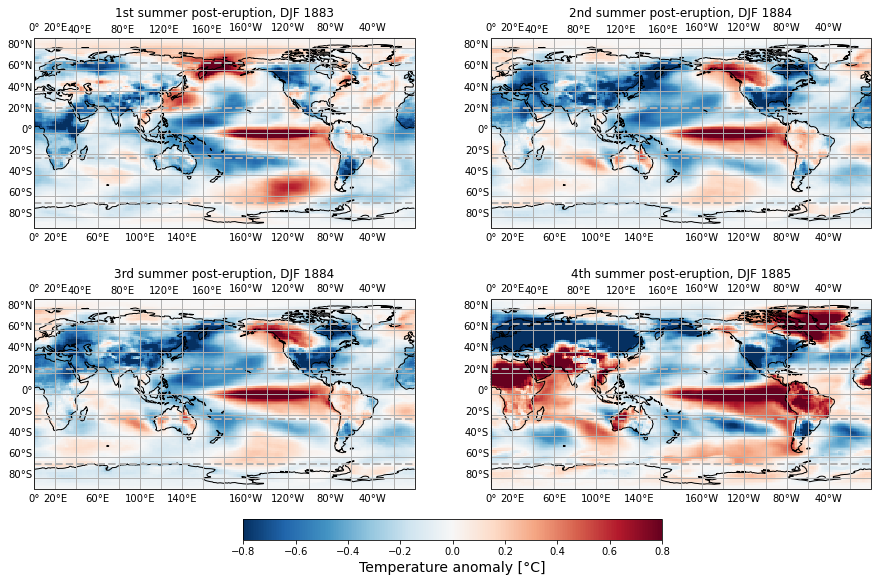

In [113]:
# plot of el nino models global monthly model mean temperature at 4 discrete time periods
fig = func2.spatial_plot(2, 2, nino_models_Glob.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Glob_nino_mods.png', dpi=300, bbox_inches='tight')

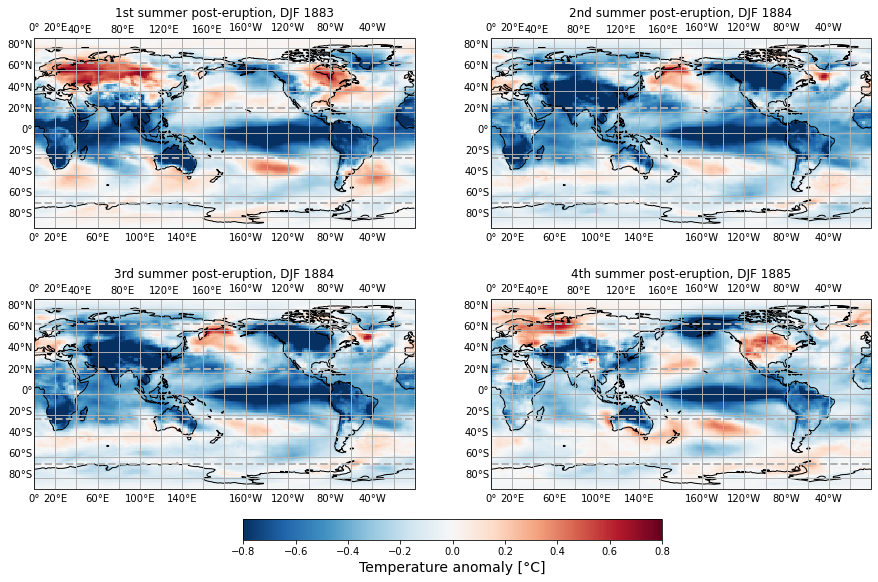

In [114]:
# plot of la nina models global monthly model mean temperature at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, nina_models_Glob.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Glob_nina_mods.png', dpi=300, bbox_inches='tight')

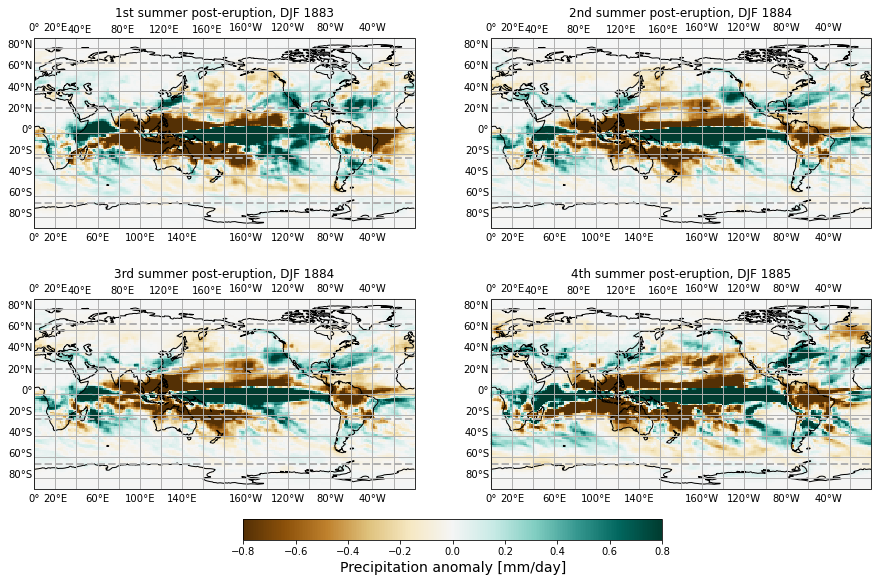

In [115]:
# plot of el nino models global monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, nino_models_Glob.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Glob_nino_mods.png', dpi=300, bbox_inches='tight')

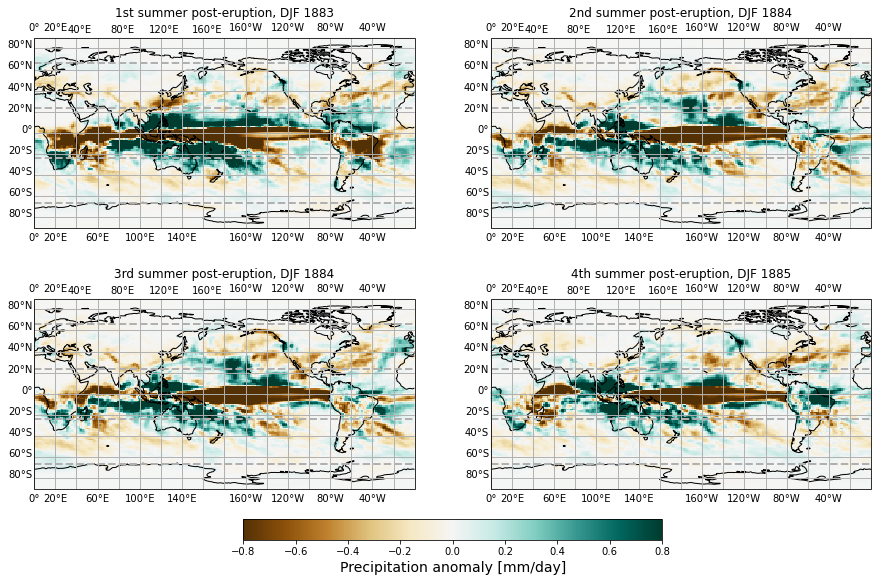

In [116]:
# plot of la nina models global monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, nina_models_Glob.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Glob_nina_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


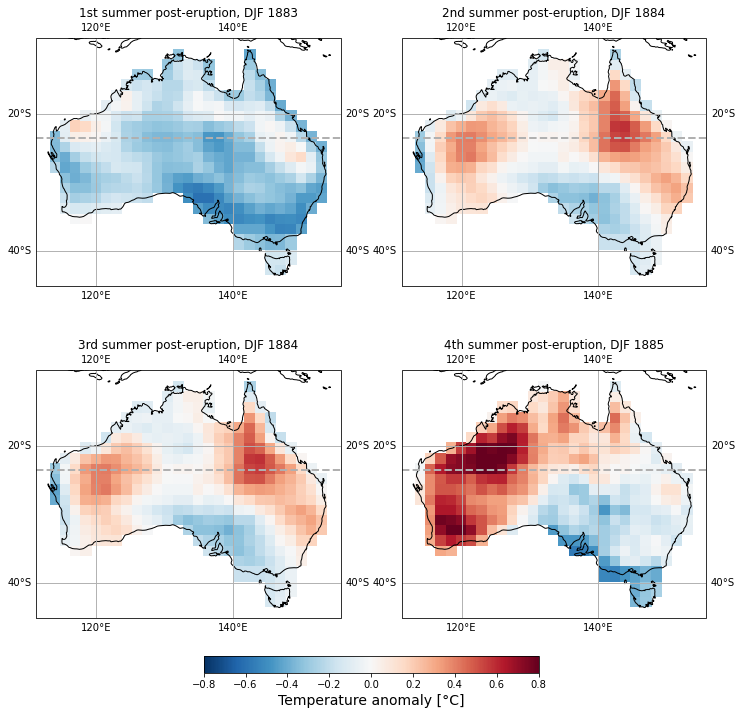

In [117]:
# plot of el nino models Australian monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, nino_models_Aus.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Aus_nino_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


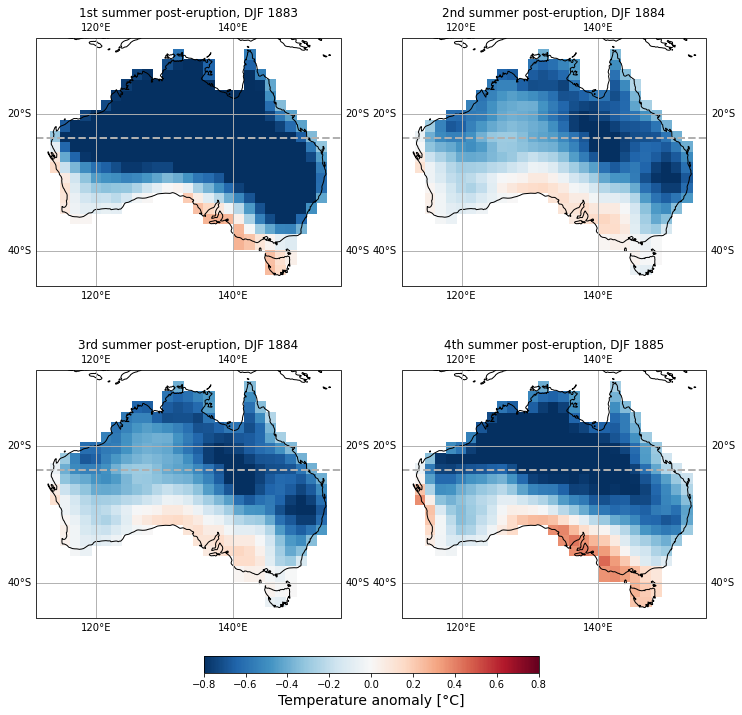

In [118]:
# plot of la nina models Australian monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, nina_models_Aus.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Aus_nina_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


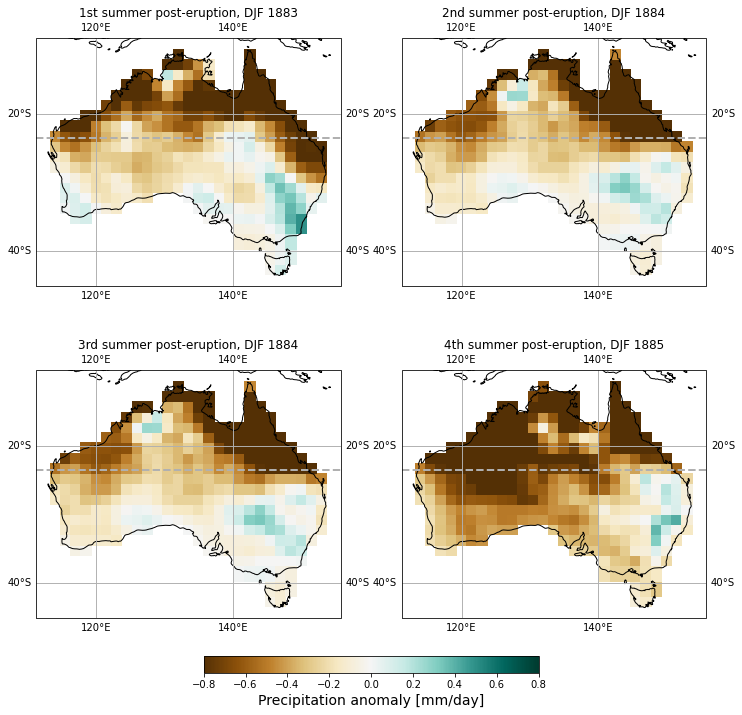

In [119]:
# plot of el nino models Australian monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, nino_models_Aus.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Aus_nino_mods.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


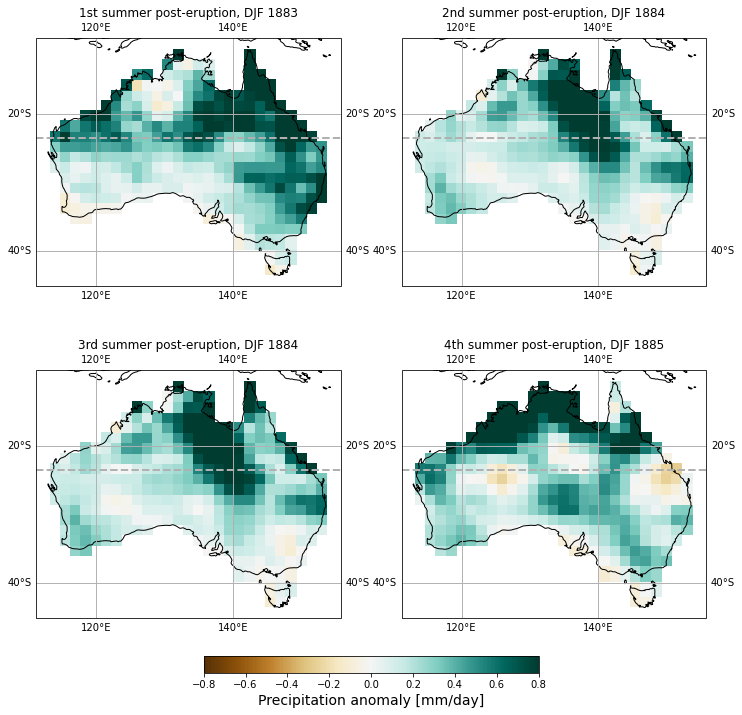

In [120]:
# plot of la nina models Australian monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, nina_models_Aus.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Aus_nina_mods.png', dpi=300, bbox_inches='tight')

## all models 

In [150]:
# select out the DJF months and take the time average for the nominated years in a specific dataset  
def DJF_sel(dataset, years):
    
    import xarray as xr
    
    # define start date (as D of each year entered) and end date (as F of following year)
    start_date=[]
    for i, vals in enumerate(years):
        s =  years[i] + '-12'
        start_date.append(s)
    start_date = pd.to_datetime(start_date)
    end_date = start_date + 3 * pd.offsets.MonthEnd()
    
    # select out DJF and take time mean and multi-model mean
    ds= []
    for j, vals in enumerate(years):
        y = dataset.sel(time=slice(start_date[j], end_date[j])).mean(dim=['model', 'time'])
        ds.append(y)
#     year0 = dataset.sel(time=slice(start_date[0], end_date[0])).mean(dim=['model', 'time'])
#     year1 = dataset.sel(time=slice(start_date[1], end_date[1])).mean(dim=['model', 'time'])
#     year2 = dataset.sel(time=slice(start_date[2], end_date[2])).mean(dim=['model', 'time'])
#     year3 = dataset.sel(time=slice(start_date[3], end_date[3])).mean(dim=['model', 'time'])

    # combine data from the 4 time periods into one dataset 
    DJF = xr.concat(ds, dim='time', coords = 'minimal')
    DJF.coords['time'] = years
    
    return DJF

In [151]:
# use function to take the multi-model mean and DJF mean for the fours years listed in K_dates
K_mmm_mon_Glob = DJF_sel(K_mon_Glob, K_dates)
K_mmm_mon_SH = DJF_sel(K_mon_SH, K_dates)
K_mmm_mon_Aus = DJF_sel(K_mon_Aus, K_dates)
K_mmm_mon_EA = DJF_sel(K_mon_EA, K_dates)

# below graphs aren't working!!

AttributeError: 'Rectangle' object has no property 'add_colorbar'

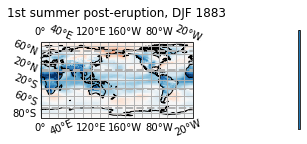

In [153]:
# plot of all models global monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, K_mmm_mon_Glob.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Glob_all_mods.png', dpi=300, bbox_inches='tight')

In [ ]:
# plot of all models global monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, K_mmm_mon_Glob.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Glob_all_mods.png', dpi=300, bbox_inches='tight')

In [ ]:
# plot of all models Australian monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, K_mmm_mon_Glob.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Aus_all_mods.png', dpi=300, bbox_inches='tight')

In [ ]:
# plot of all models Australian monthly model mean rainfall at 4 discrete time periods 
fig = func2.spatial_plot(2, 2, K_mmm_mon_Aus.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 0)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Aus_all_mods.png', dpi=300, bbox_inches='tight')